# Appetite suppressant Lac-Phe rises after consuming a mixed meal

- The mixed meal consisted of liquid meal replacement shakes and a protein bar
- Metabolomics were measured 1 hour post feeding

## Handle setup

In [9]:
# Import essential data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def download_file(file_name, github_path):
    # If running on Google Colab, use wget to download the file
    if 'google.colab' in str(get_ipython()):
        print(f'Downloading {file_name} from GitHub to Colab environment.')
        !wget --no-check-certificate {github_path} -O {file_name}
        return file_name  # The file will be downloaded to the current directory
    else:
        # For local execution, construct the path relative to the notebook directory
        local_path = os.path.join('..', 'data', file_name)  # Go up one directory and then to the data folder
        if not os.path.exists(local_path):
            raise FileNotFoundError(f"File {file_name} not found at {local_path}. Did you forget to download it?")
        print(f'Using local file {file_name}.')
        return local_path

# URL components for GitHub raw content
github_base_url = 'https://raw.githubusercontent.com/barryfscott/Metformin-Feeding-Lac-Phe-Analysis/main/data/'

# File names to download
files_to_download = [
    'Kannt_feeding_metabolomics.xlsx',
    'unknown_Metabolon_metabolites_renamed.xlsx' 
    # Add more files as needed
]

# Download each file and store the paths
paths_to_files = {}
for file_name in files_to_download:
    github_path = f'{github_base_url}{file_name}'
    file_path = download_file(file_name, github_path)
    paths_to_files[file_name] = file_path


Using local file Kannt_feeding_metabolomics.xlsx.
Using local file unknown_Metabolon_metabolites_renamed.xlsx.


## Data Source and Preparation
The dataset utilized in this study is derived from the paper titled "Short-term variability of the human serum metabolome depending on nutritional and metabolic health status", available [here](https://www.nature.com/articles/s41598-020-72914-7#Sec26). Prior to analysis, certain columns were removed using Excel for a streamlined data import process into a pandas DataFrame.


In [11]:
# Load metabolomics data with specific sheet and transpose for better manipulation
pre_post_prandial_df = pd.read_excel(paths_to_files['Kannt_feeding_metabolomics.xlsx'],
                                     sheet_name="Data_only_metabolite_name",
                                     index_col=0).T

# Convert all metabolite columns to float for numerical analysis
cols_to_convert = pre_post_prandial_df.loc[:, 'glycine':'X - 24766'].columns
pre_post_prandial_df[cols_to_convert] = pre_post_prandial_df[cols_to_convert].astype(float)

# Convert 'Time' column to a binary indicator (1 for 'Post', 0 otherwise) and add it to DataFrame
post_prandial_bool_series = pre_post_prandial_df['Time'].apply(lambda x: 1 if x == "Post" else 0)
pre_post_prandial_df = pd.concat([pre_post_prandial_df, post_prandial_bool_series.rename('PostPrandial_bool')], axis=1)

# Load participant characteristics and merge with metabolomics data based on subject ID
participant_metadata_df = pd.read_excel(paths_to_files['Kannt_feeding_metabolomics.xlsx'], sheet_name="participants_characteristics")
merged_data_df = pd.merge(participant_metadata_df, pre_post_prandial_df, how="right", left_on="Individual", right_on="SUBJECT")


## Metabolite Renaming for Clarity
To enhance the interpretability of the metabolomics data, specific metabolites, particularly N-lactoyl amino acids, were renamed from their originally reported names. This renaming process aids in the clear identification and analysis of these compounds within the dataset. Additionally, a separate list of metabolites identified as 'retired' by Metabolon was updated to reflect their current naming conventions, ensuring consistency and accuracy in data representation.


In [3]:
# Define a mapping for N-lactoyl amino acids from their originally reported names
n_lac_mapping={
"X - 13529":"N-lactoyl valine",
"X - 15497":"N-lactoyl phenylalanine",
"X - 18889":"N-lactoyl leucine",
"X - 22102":"N-lactoyl isoleucine",
"X - 19561":"N-lactoyl tyrosine",
"X - 25607":"N-lactoyl histidine",
"1-carboxyethylvaline":"N-lactoyl valine",
"1-carboxyethylphenylalanine":"N-lactoyl phenylalanine",
"1-carboxyethylleucine":"N-lactoyl leucine",
"1-carboxyethylisoleucine":"N-lactoyl isoleucine",
"1-carboxyethyltyrosine":"N-lactoyl tyrosine",
"1-carboxyethylhistidine":"N-lactoyl histidine"
}

# Apply the mapping to rename columns
pre_post_prandial_df.rename(columns=n_lac_mapping,inplace=True)

# Load and apply additional renaming from an external file
renamed_metabolites=pd.read_excel(paths_to_files["unknown_Metabolon_metabolites_renamed.xlsx"],sheet_name="metabolites_renamed")
renamed_dict= renamed_metabolites[renamed_metabolites["Retired for"].isna()==False].set_index("Name")["Retired for"].to_dict()
pre_post_prandial_df.rename(columns=renamed_dict,inplace=True)

## Function for plotting metabolite levels before and after eating, categorized by health status

In [4]:
def plot_metabolite_levels(df, metabolite):
    # This function plots metabolite levels before and after eating, categorized by health status
    pivot_df = df.pivot_table(index=['DAY', 'SUBJECT', 'Health'], columns='Time', values=metabolite).reset_index()
    
    # Define health order for sorting
    health_order = ['Healthy', 'prediabetic', 'diabetic']
    pivot_df['Health'] = pd.Categorical(pivot_df['Health'], categories=health_order, ordered=True)
    pivot_df.sort_values('Health', inplace=True)
    
    # Setup FacetGrid for plotting
    grid = sns.FacetGrid(pivot_df, col='Health', sharey=True, col_wrap=3, height=4, col_order=health_order)
    
    # Internal function to plot lines for each subject
    def plot_lines(data, color, **kwargs):
        for (subject, health), group in data.groupby(['SUBJECT', 'Health']):
            if len(group) > 1:
                plt.plot(['Pre', 'Post'], [group['Pre'].values, group['Post'].values], marker='o', color=color, alpha=0.5)
    
    # Apply plotting function and add average bars
    grid.map_dataframe(plot_lines, color='skyblue')
    for ax, (health, group_data) in zip(grid.axes.flatten(), pivot_df.groupby('Health')):
        pre_mean = group_data['Pre'].mean()
        post_mean = group_data['Post'].mean()
        ax.bar(['Pre', 'Post'], [pre_mean, post_mean], color='orange', alpha=0.7, width=0.4)
        ax.text(0, pre_mean, f'{pre_mean:.2f}', ha='center', va='bottom')
        ax.text(1, post_mean, f'{post_mean:.2f}', ha='center', va='bottom')
    
    # Customize and display the plot
    grid.set_titles(col_template="{col_name}")
    grid.set_axis_labels("", metabolite)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f'{metabolite} Levels Before and After Eating', fontsize=16)
    plt.show()

    



## Analysis of N-lactoyl Phenylalanine (Lac-Phe) Levels in Response to a Mixed Meal

This visualization presents the variations in N-lactoyl phenylalanine (Lac-Phe) concentrations before and after the consumption of a mixed meal, categorized by metabolic health status. It offers an illustrative comparison with Figure 3c from the original publication, using the same dataset but visualized here via Python’s Matplotlib and Seaborn libraries instead of GraphPad Prism. The individual data points represent subjects' metabolite levels, while the bars indicate the mean values for each group.

_To view the code responsible for generating this plot, please refer to the `plot_metabolite_levels` function within the Jupyter notebook._


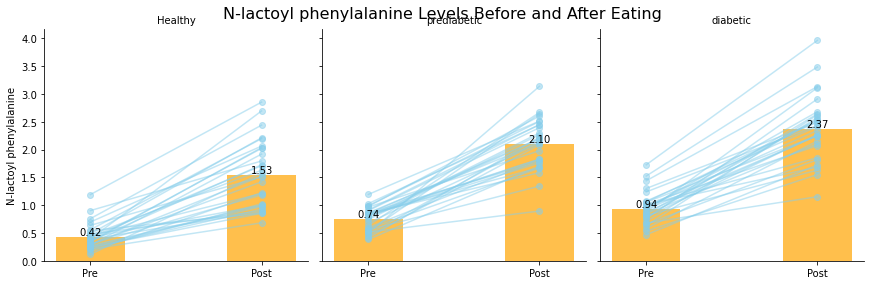

In [5]:
plot_metabolite_levels(pre_post_prandial_df, 'N-lactoyl phenylalanine')

## Plot Lac-Val (N-lactoyl valine) before and after a mixed meal

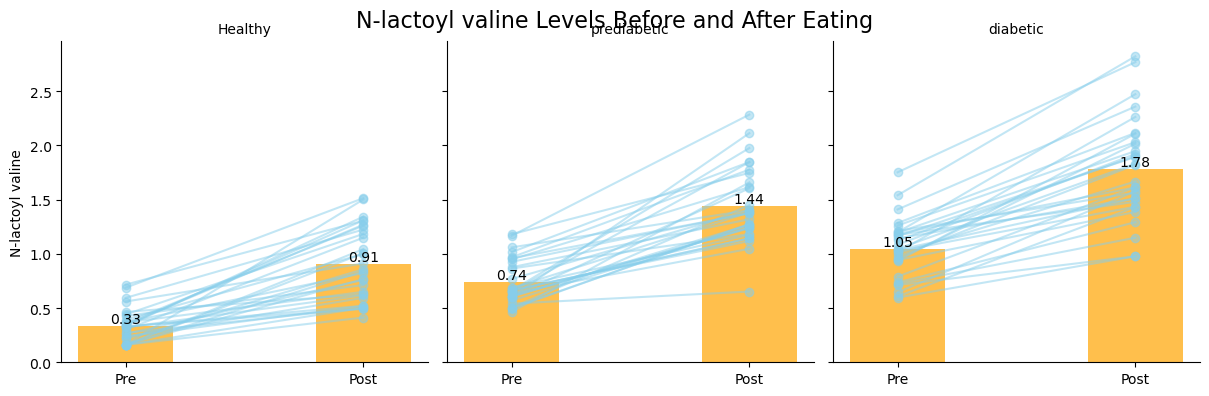

In [6]:
plot_metabolite_levels(pre_post_prandial_df, 'N-lactoyl valine')